In [1]:
from dask.distributed import Client, LocalCluster
# from dask_jobqueue import SLURMCluster

cluster = LocalCluster()
# cluster = SLURMCluster(cores=12, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='118GB', interface='ib0'
#                       ) 
cluster.scale(12)
# # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:45537 Dashboard: http://127.0.0.1:43737/status,Cluster Workers: 12 Cores: 72 Memory: 202.37 GB


In [1]:
import xarray as xr
import numpy as np
import xscale
import gsw
import os.path as op
from xgcm.grid import Grid as xgrid
import xomega as xo
from xhistogram.xarray import histogram as xhist
from scipy.interpolate import PchipInterpolator as pchip

from matplotlib.gridspec import GridSpec
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ddir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
xtra = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02X-S'
scratch = '/scratch/cnt0024/hmg2840/tuchida/temp'

In [19]:
g = 9.81
Ce = 0.01
Cp = 4e3
rhoConst = 1e3
ys,ye = (2000,2500)
xs,xe = (2300,3100)
zchunk = 4
z10 = 6
zcoef0 = .5*g
znad = 1.

dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc'), chunks={'z':zchunk})
dsmask

<xarray.Dataset>
Dimensions:       (t: 1, x: 8354, y: 4729, z: 300)
Dimensions without coordinates: t, x, y, z
Data variables:
    nav_lon       (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    time_counter  (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    tmask         (t, z, y, x) int8 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    umask         (t, z, y, x) int8 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    vmask         (t, z, y, x) int8 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    fmask         (t, z, y, x) int8 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    tmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    umaskutil     (t, y, x) int8 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    vmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    fmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    glamt         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    glamu         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    glamv         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    glamf         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    gphit         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    gphiu         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    gphiv         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    gphif         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e1t           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e1u           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e1v           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e1f           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e2t           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e2u           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e2v           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e2f           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    ff            (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    mbathy        (t, y, x) int16 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    misf          (t, y, x) int16 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    isfdraft      (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e3t_0         (t, z, y, x) float64 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    e3u_0         (t, z, y, x) float64 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    e3v_0         (t, z, y, x) float64 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    e3w_0         (t, z, y, x) float64 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    gdept_0       (t, z, y, x) float32 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    gdepu         (t, z, y, x) float32 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    gdepv         (t, z, y, x) float32 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    gdepw_0       (t, z, y, x) float32 dask.array<chunksize=(1, 4, 4729, 8354), meta=np.ndarray>
    gdept_1d      (t, z) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    gdepw_1d      (t, z) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    e3t_1d        (t, z) float64 dask.array<chunksize=(1, 4), meta=np.ndarray

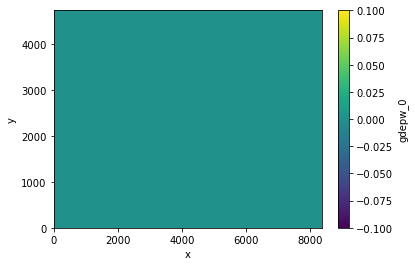

In [5]:
dsmask.gdepw_0[0,0].plot()

In [16]:
# # gdepw = dsmask.gdepw_0[0].where(dsmask.tmask[0]!=0.).chunk({'z':-1,'x':100,'y':100}).max('z').compute()
# # gdepu = dsmask.gdepu[0].where(dsmask.umask[0]!=0.).chunk({'z':-1,'x':100,'y':100}).max('z').compute()
# # gdepv = dsmask.gdepv[0].where(dsmask.vmask[0]!=0.).chunk({'z':-1,'x':100,'y':100}).max('z').compute()
# # gdept = dsmask.gdept_0[0].where(dsmask.tmask[0]!=0.).chunk({'z':-1,'x':100,'y':100}).max('z').compute()
mbathy = dsmask.mbathy[0]
# gdepw = dsmask.gdepw_0[0].where(dsmask.gdepw_0[0].z <= mbathy).max('z')
# # gdept = dsmask.gdept_0[{'t':0,'z':mbathy}]
# # gdepu = dsmask.gdepu[{'t':0,'z':mbathy}]
# # gdepv = dsmask.gdepv[{'t':0,'z':mbathy}]
# gdepw.plot(figsize=(16,12), cmap='cividis')
# gdepw.to_dataset(name="gdepw").to_netcdf('/scratch/cnt0024/hmg2840/tuchida/temp/gdepw_eNATL60.nc')
gdepw = xr.open_dataset(op.join(scratch,'gdepw_eNATL60.nc')).gdepw
gdepw
# dsmask.mbathy[0].where(dsmask.mbathy[0]>0).plot()

<xarray.DataArray 'gdepw' (y: 4729, x: 8354)>
[39506066 values with dtype=float32]
Dimensions without coordinates: y, x

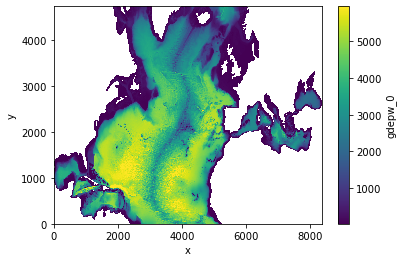

In [9]:
gdepw.plot()

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


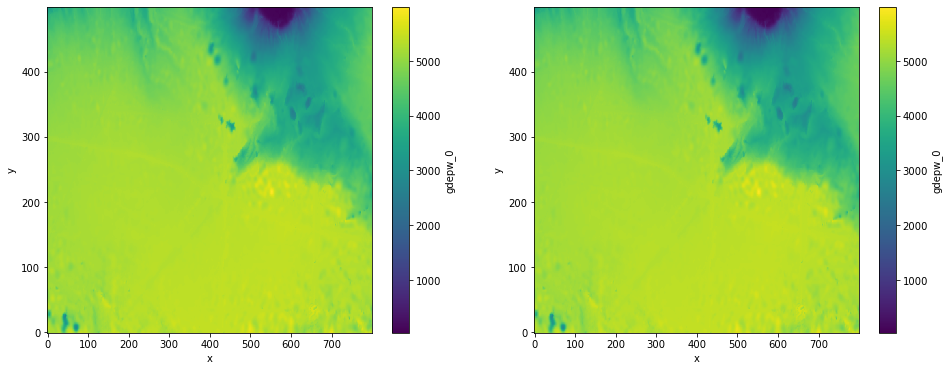

In [5]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
dsmask.gdepw_0.sel(y=slice(ys,ye),
                   x=slice(xs,xe))[{'t':0,'z':dsmask.mbathy[0].sel(y=slice(ys,ye),
                                                                   x=slice(xs,xe)).load()}].plot(ax=ax1)
gdepw.sel(y=slice(ys,ye),x=slice(xs,xe)).plot(ax=ax2)

In [7]:
print(np.testing.assert_array_equal(dsmask.gdepw_0.sel(y=slice(ys,ye),
                                                       x=slice(xs,xe))[{'t':0,'z':dsmask.mbathy[0].sel(y=slice(ys,ye),
                                                                                                       x=slice(xs,xe)).load()}],
                                    gdepw.sel(y=slice(ys,ye),x=slice(xs,xe))))

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


None


In [5]:
At = (dsmask.e1t * dsmask.e2t)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
Au = (dsmask.e1u * dsmask.e2u)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
Av = (dsmask.e1v * dsmask.e2v)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
A = (dsmask.e1u * dsmask.e2v)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e1u = dsmask.e1u[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e2u = dsmask.e2u[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e1v = dsmask.e1v[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e2v = dsmask.e2v[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e2t = dsmask.e2t[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e1t = dsmask.e1t[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e2v = dsmask.e2v[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e1u = dsmask.e1u[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e2u = dsmask.e2u[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e1v = dsmask.e1v[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e3t = dsmask.e3t_1d[0]
e3w = dsmask.e3w_1d[0]

f = xr.apply_ufunc(gsw.f, dsmask.nav_lat.sel(y=slice(ys,ye),x=slice(xs,xe)),
                  dask='parallelized', output_dtypes=['float',])
beta = ((f*e1t).diff('y') * Av[1:]**-1).mean()
f0 = f.mean()

In [9]:
dsT = xr.open_dataset(op.join(xtra,'00896401-00950400/eNATL60-BLBT02X_1h_20100220_20100316_gridT_20100315-20100315.nc'),
                      chunks={'deptht':zchunk}
                     ).sel(deptht=slice(None,None))
dsS = xr.open_dataset(op.join(xtra,'00896401-00950400/eNATL60-BLBT02X_1h_20100220_20100316_gridS_20100315-20100315.nc'),
                      chunks={'deptht':zchunk}
                     ).sel(deptht=slice(None,None))
d2D = xr.open_dataset(op.join(xtra,'00896401-00950400/eNATL60-BLBT02X_1h_20100220_20100316_gridT-2D_20100315-20100315.nc'),
                     )

#         if i == days[0,0]:
maskT = dsmask.tmask[0].sel(y=slice(ys,ye),x=slice(xs,xe)
                           ).isel(z=slice(None,len(dsT.deptht)))

CT03 = dsT.votemper[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                           ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                               ) != 0.)
SA03 = dsS.vosaline[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                           ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                               ) != 0.)
ssh03 = d2D.sossheig[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                            ).where(xr.DataArray(maskT.data[0], dims=['y','x']
                                                ) != 0.)
rho03 = xr.apply_ufunc(gsw.sigma0, SA03, CT03, dask='parallelized', output_dtypes=[float,]) + 1e3
b03 = -g*(1.-rho03*1e-3)
rho03

<xarray.DataArray (deptht: 300, y: 500, x: 800)>
dask.array<add, shape=(300, 500, 800), dtype=float64, chunksize=(4, 500, 800), chunktype=numpy.ndarray>
Coordinates:
  * deptht        (deptht) float64 0.4805 1.559 2.794 ... 5.975e+03 6.025e+03
    nav_lat       (y, x) float32 36.69535 36.695553 ... 43.21733 43.217693
    nav_lon       (y, x) float32 -59.623344 -59.606667 ... -46.464603 -46.447792
    time_counter  datetime64[ns] 2010-03-15T23:30:00
Dimensions without coordinates: y, x

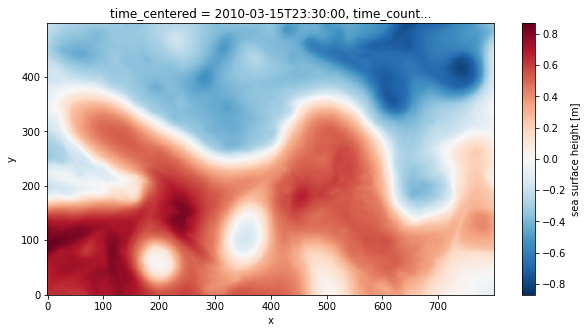

In [11]:
ssh03.plot(figsize=(10,5))

In [18]:
e3t03 = e3t.where(e3t.z<=mbathy.sel(y=slice(ys,ye),x=slice(xs,xe))) * (1 + ssh03*gdepw.sel(y=slice(ys,ye),x=slice(xs,xe))**-1)
e3w03 = e3w.where(e3w.z<=mbathy.sel(y=slice(ys,ye),x=slice(xs,xe))) * (1 + ssh03*gdepw.sel(y=slice(ys,ye),x=slice(xs,xe))**-1)
e3w03

<xarray.DataArray (z: 300, y: 500, x: 800)>
dask.array<mul, shape=(300, 500, 800), dtype=float64, chunksize=(4, 500, 800), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] 2010-03-15T23:30:00
Dimensions without coordinates: z, y, x